In [1]:
import sys
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import numpy as np
import joblib, os, h5py
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import shutil 

print("Python interpreter binary location:", sys.executable)

Python interpreter binary location: /n/groups/datta/tim_sainburg/conda_envs/peromoseq/bin/python3


### Load google drive recording information

In [2]:
import requests

In [3]:
from datetime import datetime, timedelta
#import requests
from io import BytesIO

In [4]:
spreadsheet_url = 'https://docs.google.com/spreadsheet/ccc?key=14HIqUaSl_n-91hpAvmACY_iVY9nLKdlA6qklhxfZon0&output=csv&gid=0'

In [5]:
def get_datetime(row):
    dt = datetime.strptime(f"{row['Date']}_{row['Time']}", "%m-%d-%y_%H:%M")
    if pd.isnull(row.Seconds) == False:
        dt = dt + timedelta(seconds=row.Seconds)
    return dt

In [6]:
response = requests.get(spreadsheet_url)
individual_df = pd.read_csv(BytesIO(response.content))
individual_df = individual_df[individual_df.Identifiers.isnull() == False]
individual_df["Identifiers"] = individual_df["Identifiers"].astype(int)
individual_df["age"] = individual_df["Age (days)"].astype(int)
# get datetime for each row
individual_df["datetime"] = [
    get_datetime(row)
    for idx, row in individual_df.iterrows()
]
individual_df = individual_df.reset_index(drop=True)

In [7]:
print(f'N individuals: {len(individual_df)}')

N individuals: 309


In [8]:
individual_df[:3]

,rid,Date,Time,Seconds,Identifiers,Weight (g),Strain,Sex,DOB,Cage occupants,Experimenter,Rig,Trial,Age (days),Notes,calibration_id,Data storage location,age,datetime
0,23-09-27-14-46-49-522610,09-27-23,14:46,NaN,38209,16.0,NUB,M,7-21-23,38209,TS,1.0,1.0,68.0,using bad scale,23-09-28-17-34-02-003662,NaN,68,2023-09-27 14:46:00
1,23-09-27-16-50-11-334366,09-27-23,16:50,NaN,38068,15.0,NUB,F,7-3-23,"38068, 38208",TS,1.0,1.0,86.0,using bad scale,23-09-28-17-34-02-003662,NaN,86,2023-09-27 16:50:00
2,23-09-27-16-13-10-344746,09-27-23,16:13,NaN,38208,17.0,NUB,F,7-21-23,"38068, 38208",TS,1.0,1.0,68.0,using bad scale,23-09-28-17-34-02-003662,NaN,68,2023-09-27 16:13:00


In [11]:
recording_row = individual_df[individual_df.rid == '23-10-26-15-31-07-651606'].iloc[0]

In [12]:
#recording_row = individual_df.iloc[0]
#recording_row = individual_df.iloc[-1]

In [13]:
recording_row

rid                        23-10-26-15-31-07-651606
Date                                       10-26-23
Time                                          15:31
Seconds                                         NaN
Identifiers                                   38201
Weight (g)                                     17.6
Strain                                           AM
Sex                                               F
DOB                                         7/18/23
Cage occupants           38196, 38197, 38200, 38201
Experimenter                                     TS
Rig                                             1.0
Trial                                           1.0
Age (days)                                    100.0
Notes                                           NaN
calibration_id             23-10-26-13-40-15-855341
Data storage location                           NaN
age                                             100
datetime                        2023-10-26 15:31:00
Name: 49, dt

In [262]:
reformatted_output_directory = Path('/n/groups/datta/kpts_pipeline/pero_240925/results')

In [15]:
predictions = list((reformatted_output_directory / "triangulation" / recording_row.rid).glob('predictions_3d*.mmap'))[0]

In [135]:
#prediction_file = "/n/groups/datta/tim_sainburg/projects/23-09-29-peromoseq/data/keypoints/240508_mmpose_predictions/LL/sessions/24-08-16-14-45-39-561890/3D_240927.h5"
prediction_file = "/n/groups/datta/tim_sainburg/projects/23-09-29-peromoseq/data/keypoints/240508_mmpose_predictions/am/sessions/38201/23-10-26-15-31-07-651606/3D_240927.h5"

In [136]:
import h5py

with h5py.File(prediction_file, 'r') as file:
    print(list(file.keys()))
    predictions_3d = np.array(file["positions_3D"])

['camera_calibration_order', 'confidences_2D', 'keypoint_names', 'positions_2D', 'positions_2D_reprojections', 'positions_3D', 'reprojection_errors', 'skeleton']


In [137]:
def load_memmap_from_filename(filename):
    # Extract the metadata from the filename
    parts = filename.name.rsplit(".", 4)  # Split the filename into parts
    dtype_str = parts[-3]  # Get the dtype part of the filename
    shape_str = parts[-2]  # Get the shape part of the filename
    shape = tuple(map(int, shape_str.split("x")))  # Convert shape string to a tuple of integers
    # Load the array using numpy memmap
    array = np.memmap(filename, dtype=dtype_str, mode="r", shape=shape)
    return array


In [138]:
#predictions_3d = np.array(load_memmap_from_filename(predictions))

In [139]:
predictions_3d.shape

(215906, 25, 3)

In [140]:
!ls {reformatted_output_directory}

2D_predictions	 egocentric_alignment  size_normalization  triangulation
arena_alignment  gimbal		       subject_df.pickle


In [141]:
calibration_folder = list(Path('/n/groups/datta/tim_sainburg/projects/23-09-29-peromoseq/data/jarvis/calibrations').glob(f'**/{recording_row.calibration_id}'))[0]

In [142]:
!ls {calibration_folder/'CalibrationParameters'}

BackLeft.yaml	Bottom.yaml	FrontRight.yaml
BackRight.yaml	FrontLeft.yaml	Top.yaml


In [143]:
import multicam_calibration as mcc

In [144]:
# load calibration
all_extrinsics, all_intrinsics, camera_names = mcc.load_calibration(
    (calibration_folder/"CalibrationParameters").as_posix(), "jarvis"
)

In [145]:
np.any(np.isnan(predictions_3d))

True

In [146]:
def nan_to_preceding(arr):
    # Make a copy of the array to avoid modifying the original array
    result = arr.copy()

    # Iterate over each element in the first dimension
    for i in range(1, arr.shape[0]):
        mask = np.isnan(result[i])  # Identify the NaN values
        result[i][mask] = result[i - 1][mask]  # Replace NaNs with preceding values

    return result

In [147]:
predictions_3d = nan_to_preceding(predictions_3d)

In [148]:
np.min(predictions_3d)

-986.7192744041555

In [149]:
positions = predictions_3d

In [150]:
# get reprojections
positions_2D_reprojections = (
    np.zeros((positions.shape[0], len(camera_names), positions.shape[1], 2)) * np.nan
)
for cam in range(len(camera_names)):
    extrinsics = all_extrinsics[cam]
    camera_matrix, dist_coefs = all_intrinsics[cam]
    positions_2D_reprojections[:, cam, :, :] = mcc.project_points(
        positions,
        extrinsics=extrinsics,
        camera_matrix=camera_matrix,
        dist_coefs=dist_coefs,
    )

In [151]:
positions_2D_reprojections.shape

(215906, 6, 25, 2)

In [152]:
video_folder = list(Path("/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/").glob(f"**/{recording_row.rid}"))[0]
video_folder

PosixPath('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/am/sessions/38201/23-10-26-15-31-07-651606')

In [153]:
recording_videos = list(video_folder.glob('*.mp4'))

In [154]:
recording_videos

[PosixPath('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/am/sessions/38201/23-10-26-15-31-07-651606/BackLeft.40362566.100813.mp4'),
 PosixPath('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/am/sessions/38201/23-10-26-15-31-07-651606/BackLeft.40362566.108014.mp4'),
 PosixPath('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/am/sessions/38201/23-10-26-15-31-07-651606/BackLeft.40362566.115215.mp4'),
 PosixPath('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/am/sessions/38201/23-10-26-15-31-07-651606/BackLeft.40362566.122416.mp4'),
 PosixPath('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/am/sessions/38201/23-10-26-15-31-07-651606/BackLeft.40362566.129617.mp4'),
 PosixPath('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/am/sessions/38201/23-10-26-15-31-07-651606/BackLeft.40362566.136818.mp4'),
 PosixPath('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/am/sessions/38201/23-10-2

In [155]:
video_path = recording_videos[0]

In [156]:
video_path

PosixPath('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/am/sessions/38201/23-10-26-15-31-07-651606/BackLeft.40362566.100813.mp4')

In [243]:
video_path = Path('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/am/sessions/38201/23-10-26-15-31-07-651606/BackLeft.40362566.122416.mp4')
video_path = Path('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/am/sessions/38201/23-10-26-15-31-07-651606/BackRight.40362557.122416.mp4')
#video_path = Path('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/NUB/sessions/38209/23-09-27-14-46-49-522610/BackLeft.40362566.7200.mp4')
#video_path = Path('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/LL/sessions/24-08-16-14-45-39-561890/BackRight.40362557.mp4')

In [244]:
#video_path = Path('/n/groups/datta/tim_sainburg/datasets/peromoseq/remux/baseline/am/sessions/38201/23-10-26-15-31-07-651606/BackLeft.40362566.mp4')
 

In [245]:
camera = "BackRight"
start_frame = 122382

In [246]:
camera_names = [i.split('.')[0] for i in camera_names]

In [247]:
camera_names

['BackLeft', 'BackRight', 'Bottom', 'FrontLeft', 'FrontRight', 'Top']

In [248]:
cam_idx = np.where(np.array(camera_names) == camera)[0][0]
cam_idx

1

In [249]:
n_frames = 7198

In [250]:
np.any(np.isnan(positions_2D_reprojections))

False

In [251]:
positions_2D_reprojections.shape

(215906, 6, 25, 2)

In [252]:
start_frame

122382

In [253]:
kpts_sample = positions_2D_reprojections[start_frame:start_frame + n_frames, cam_idx]
kpts_sample.shape

(7198, 25, 2)

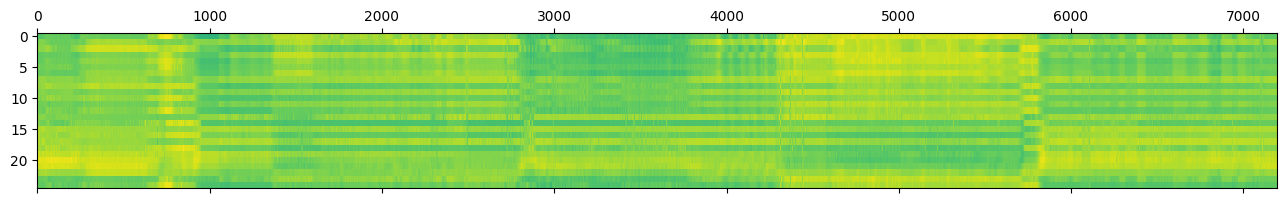

In [254]:
plt.matshow(kpts_sample[:, :, 0].T, aspect='auto')

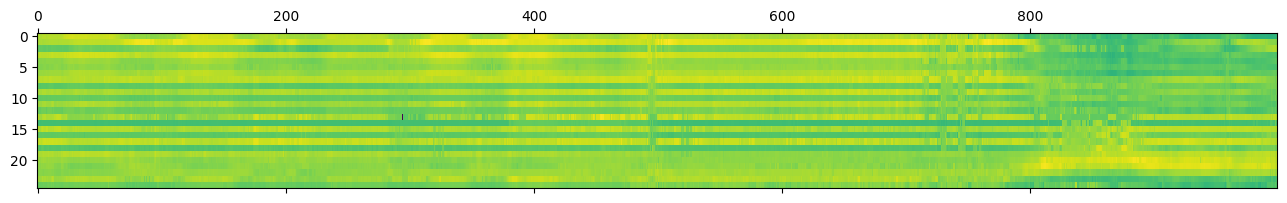

In [255]:
plt.matshow(kpts_sample[2000:3000, :, 0].T, aspect='auto')

In [256]:
confidences = np.ones(kpts_sample.shape[:-1])

In [257]:
import cv2
from tqdm.auto import tqdm

In [258]:
def generate_keypoint_video(
    output_directory: Path,
    video_path: Path,
    keypoint_coords: np.ndarray,
    keypoint_conf: np.ndarray,  # New parameter for keypoint confidence
    keypoint_info: dict,
    skeleton_info: dict,
    max_frames = None,
):
    """
    Generates a video with keypoint predictions overlaid on the original video frames.

    Parameters:
    -----------
    output_directory : Path
        Directory where the output video will be saved.
        
    video_path : Path
        Path to the input video file.
        
    keypoint_coords : np.ndarray
        Array of shape (#frames, #keypoints, 2) containing the coordinates of keypoints for each frame.
        
    keypoint_conf : np.ndarray
        Array of shape (#frames, #keypoints) containing the confidence values (0-1) for each keypoint in each frame.
        
    keypoint_info : dict
        Dictionary containing information about the keypoints. Each key in the dictionary represents a keypoint ID, and the 
        value is another dictionary with the following structure:
        {
            'name': str,       # Keypoint name
            'id': int,         # Keypoint ID
            'color': list,     # RGB color for the keypoint [R, G, B]
            'type': str,       # Keypoint type (e.g., 'upper', 'lower')
            'swap': str        # Name of the corresponding left/right keypoint to be swapped (for symmetry)
        }
        
    skeleton_info : dict
        Dictionary containing information about the skeleton. Each key in the dictionary represents a skeleton link ID, and 
        the value is another dictionary with the following structure:
        {
            'link': tuple,     # Tuple containing the names of the two keypoints that form the link
            'id': int,         # Link ID
            'color': list      # RGB color for the link [R, G, B]
        }

    Returns:
    --------
    None
        The function saves the output video with keypoints and skeletons overlaid to the specified output directory.

    Raises:
    -------
    ValueError
        If the input video cannot be opened.
    
    Example:
    --------
    output_directory = Path('/output/directory')
    video_path = Path('/path/to/video.mp4')
    keypoint_coords = np.load('keypoint_coords.npy')  # Load your keypoints array
    keypoint_conf = np.load('keypoint_conf.npy')  # Load your keypoint confidence array
    keypoint_info = {
        0: {'name': 'nose_tip', 'id': 0, 'color': [120, 184, 181], 'type': 'upper', 'swap': ''},
        # Add other keypoints as needed
    }
    skeleton_info = {
        0: {'link': ('tail_base', 'spine_low'), 'id': 0, 'color': [173, 160, 183]},
        # Add other links as needed
    }

    generate_keypoint_video(output_directory, video_path, keypoint_coords, keypoint_conf, keypoint_info, skeleton_info)
    """
    
    # Open the input video
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Create the VideoWriter object
    output_path = output_directory / (video_path.stem + "_with_keypoints.mp4")
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))

    frame_idx = 0
    if max_frames is not None:
        total_frames = min([max_frames, total_frames])

    with tqdm(total=total_frames, desc="Processing frames") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Create an overlay for drawing
            overlay = frame.copy()

            # Draw keypoints
            for kp_idx, kp_info in keypoint_info.items():
                if frame_idx < len(keypoint_coords) and kp_idx < keypoint_coords.shape[1]:
                    x, y = keypoint_coords[frame_idx, kp_idx]
                    conf = keypoint_conf[frame_idx, kp_idx]
                    color = tuple(kp_info["color"])
                    alpha = conf  # Alpha value is based on the confidence (0-1)
                    if conf > 0:  # Only draw if confidence is greater than 0
                        overlay = cv2.circle(overlay, (int(x), int(y)), radius=4, color=color, thickness=-1)

            # Apply the overlay with alpha blending for keypoints
            cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

            # Draw skeleton
            for link_info in skeleton_info.values():
                kp1_name, kp2_name = link_info["link"]
                kp1_id = next((kp["id"] for kp in keypoint_info.values() if kp["name"] == kp1_name), None)
                kp2_id = next((kp["id"] for kp in keypoint_info.values() if kp["name"] == kp2_name), None)

                if kp1_id is not None and kp2_id is not None:
                    if frame_idx < len(keypoint_coords) and kp1_id < keypoint_coords.shape[1] and kp2_id < keypoint_coords.shape[1]:
                        x1, y1 = keypoint_coords[frame_idx, kp1_id]
                        x2, y2 = keypoint_coords[frame_idx, kp2_id]
                        kp1_conf = keypoint_conf[frame_idx, kp1_id]
                        kp2_conf = keypoint_conf[frame_idx, kp2_id]
                        color = tuple(link_info["color"])
                        alpha = min(kp1_conf, kp2_conf)  # Alpha value is the minimum confidence of the link
                        if kp1_conf > 0 and kp2_conf > 0:  # Only draw if both confidence values are greater than 0
                            overlay = cv2.line(overlay, (int(x1), int(y1)), (int(x2), int(y2)), color=color, thickness=2)

            # Apply the overlay with alpha blending for skeleton
            cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

            # Write the frame with keypoints and skeletons to the output video
            out.write(frame)
            frame_idx += 1
            pbar.update(1)
            if max_frames and frame_idx >= max_frames:
                break

    # Release video objects
    cap.release()
    out.release()
    print(f"Video saved to: {output_path}")

In [259]:
video_output_directory = Path('/n/groups/datta/tim_sainburg/projects/23-09-29-peromoseq/data/kpt_output_video/reprojection')
video_output_directory.mkdir(parents=True, exist_ok=True)

In [260]:
from multicamera_airflow_pipeline.tim_240731.skeletons.sainburg25pt import dataset_info

In [261]:
generate_keypoint_video(
    output_directory = video_output_directory, 
    video_path = video_path,
    keypoint_coords = kpts_sample,
    keypoint_conf = confidences,
    keypoint_info = dataset_info["keypoint_info"],
    skeleton_info = dataset_info["skeleton_info"],
    max_frames = None,
)

Processing frames:   0%|          | 0/7198 [00:00<?, ?it/s]

Video saved to: /n/groups/datta/tim_sainburg/projects/23-09-29-peromoseq/data/kpt_output_video/reprojection/BackRight.40362557.122416_with_keypoints.mp4
